_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: *Jannis Ahlert, Julius Grote , Hun Seok Choi*

LLM Disclaimer: *Github Copilot and Chat gpt, used for autompletion and debugging.*

# Coding Lab 2

## Introduction

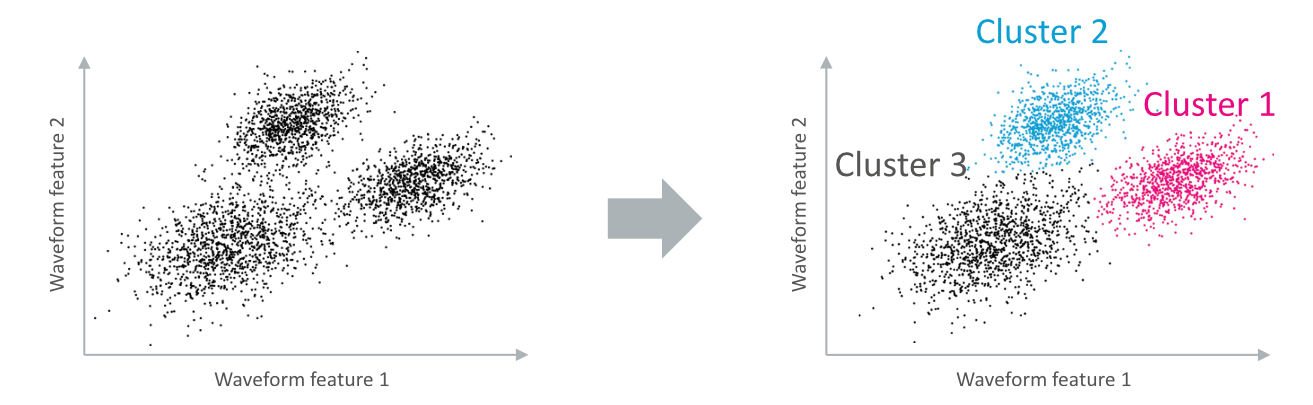

In this coding lab, we continue with the data from the first coding lab and finalize the Spike Sorting pipeline.
In particular, we use the created feature space to identify individual clusters by fitting a Gaussian Mixture Model.
To verify that this model does what we want, we first create a synthetic Toy Dataset and apply the model to that.

- __Data__: Use the saved data `nds_cl_1_*.npy` from Coding Lab 1. Or, if needed, download the data files ```nds_cl_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

In [10]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from __future__ import annotations
from scipy.special import gamma

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-05-03 16:38:20CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.35.0

sklearn: 1.6.1

sklearn   : 1.6.1
scipy     : 1.15.2
numpy     : 2.2.5
matplotlib: 3.10.1

Watermark: 2.5.0



In [2]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [3]:
# replace by path to your solutions
b = np.load("../data/nds_cl_1_features.npy")
s = np.load("../data/nds_cl_1_spiketimes_s.npy")
t = np.load("../data/nds_cl_1_spiketimes_t.npy")
w = np.load("../data/nds_cl_1_waveforms.npy")

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 2 pts*


In [4]:
def sample_data(
    n_samples: int, m: np.ndarray, S: np.ndarray, p: np.ndarray, random_seed: int = 0
) -> tuple[np.ndarray, np.ndarray]:
    """Generate n_samples samples from a Mixture of Gaussian distribution with
    means m, covariances S and priors p.

    Parameters
    ----------

    n_samples: int
        Number of samples

    m: np.ndarray, (n_clusters, n_dims)
        Means

    S: np.ndarray, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.ndarray, (n_clusters, )
        Cluster weights / probablities

    random_seed: int
        Random Seed

    Returns
    -------

    labels: np.array, (n_samples, )
        Grund truth labels.

    x: np.array, (n_samples, n_dims)
        Data points
    """
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)

    # ------------------------------------------------------
    # draw labeled points from mixture of Gaussians (1 pt)
    # ------------------------------------------------------

    # create an ndarray of shape (n_samples, ) to store the labels
    labels = np.zeros(n_samples, dtype=int)
    # create an ndarray of shape (n_samples, n_dims) to store the data points
    x = np.zeros((n_samples, m.shape[1]))

    # iterate over the number of samples
    for i in range(n_samples):
        # draw a cluster index from the multinomial distribution
        cluster = rng.multinomial(1, p).argmax()
        # draw a sample from the multivariate normal distribution
        x[i] = rng.multivariate_normal(m[cluster], S[cluster])
        # store the label
        labels[i] = cluster

    return labels, x

In [5]:
N = 1000  # total number of samples

p = np.array([0.3, 0.5, 0.2])  # percentage of each cluster
m = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])  # means

S1 = np.array([[1.0, 0.0], [0.0, 1.0]])
S2 = np.array([[2.0, 1.0], [1.0, 2.0]])
S3 = np.array([[1.0, -0.5], [-0.5, 1.0]])
S = np.stack([S1, S2, S3])  # cov

ground_labels, x = sample_data(N, m, S, p)

print(f"labels: {ground_labels.shape}, x: {x.shape}\n")

# show the first 10 samples
print("first_samples: \n", x[:10])

labels: (1000,), x: (1000, 2)

first_samples: 
 [[ 4.14147006  0.28982123]
 [ 0.36159505  1.30400005]
 [-0.70373524 -1.26542147]
 [ 0.04132598 -2.32503077]
 [ 0.36203264  3.09370838]
 [ 3.81407483 -0.36770063]
 [ 3.93063995  1.20833974]
 [ 0.56937468  2.9728995 ]
 [ 5.3687758   1.14359763]
 [ 0.21465912  0.35537271]]


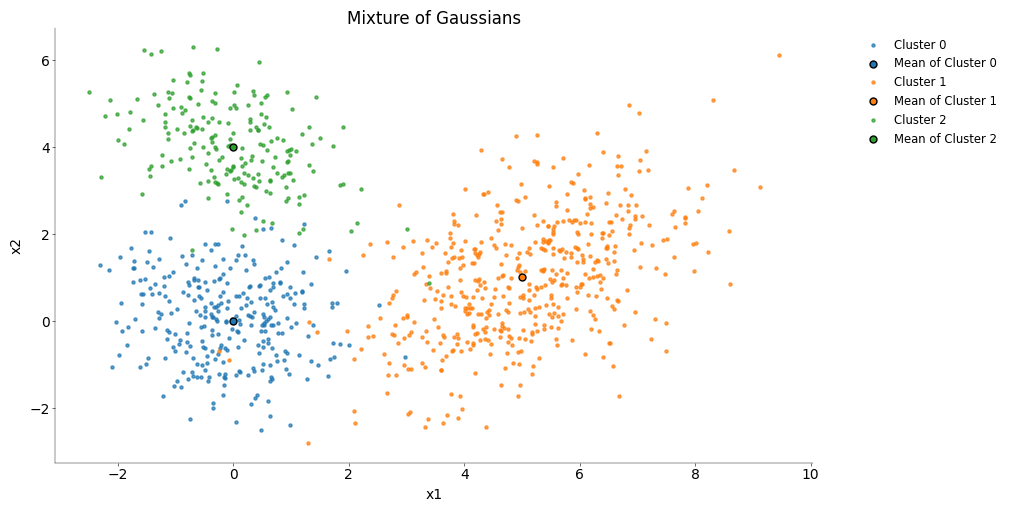

In [6]:
# ----------------------------------------------
# plot points from mixture of Gaussians (1 pt)
# ----------------------------------------------

fig, ax = plt.subplots(figsize=(10, 5), layout="constrained")

# plot the points with different colors for each cluster
for i in range(len(m)):
    ax.scatter(
        x[ground_labels == i, 0],
        x[ground_labels == i, 1],
        s=20,
        alpha=0.7,
        label=f"Cluster {i}",
    )
    ax.scatter(
        m[i, 0],
        m[i, 1],
        s=100,
        c=f"C{i}",
        edgecolors="k",
        linewidths=1,
        label=f"Mean of Cluster {i}",
    )
ax.set_title("Mixture of Gaussians")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small", ncol=1)
plt.show()

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 6 pts*


In [7]:
def fit_mog(
    x: np.ndarray,
    n_clusters: int,
    n_iters: int = 10,
    random_seed: int = 0,
    init: str = "random",
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Fit Mixture of Gaussian model using EM algo.

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    n_clusters: int
        Number of clusters

    n_iters: int
        Maximal number of iterations.

    random_seed: int
        Random Seed


    Returns
    -------

    labels: np.array, (n_samples)
        Cluster labels

    m: list or np.array, (n_clusters, n_dims)
        Means

    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    """
    # ensure reproducibility using a random number generator
    rng = np.random.default_rng(random_seed)

    # -----------
    # init (1 pt)
    # -----------

    # initialse with a random cluster assignment or k-means
    if init == "random":
        # assign the labels randomly
        labels = rng.integers(0, n_clusters, size=x.shape[0])
        # calculate the means, covariances and priors based on the random labels
        m = np.array([x[labels == i].mean(axis=0) for i in range(n_clusters)])
        S = np.array([np.cov(x[labels == i].T) for i in range(n_clusters)])
        p = np.array([np.sum(labels == i) / x.shape[0] for i in range(n_clusters)])

        print("random intialization strategy")

    elif init == "kmeans":
        # build a k-means model
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed).fit(x)
        # assign the labels based on k-means clustering
        labels = kmeans.labels_
        # calculate the means, covariances and priors based on the k-means labels
        m = kmeans.cluster_centers_
        S = np.array([np.cov(x[labels == i].T) for i in range(n_clusters)])
        p = np.array([np.sum(labels == i) / x.shape[0] for i in range(n_clusters)])

        print("kmeans intialization strategy")
    else:
        raise ValueError("init must be either 'random' or 'kmeans'")

    # init probabilities 'r' of size (n_samples, n_clusters)
    r = np.zeros((x.shape[0], n_clusters))

    # -------------------------
    # EM maximisation (3 pts)
    # -------------------------

    for step in range(n_iters):

        print(f"Step {step + 1}: E-Step\n")
        # E step
        # Evaluate the posterior probablibities `r`
        # using the current values of `m` and `S`
        for i in range(n_clusters):
            r[:, i] = p[i] * sp.stats.multivariate_normal.pdf(x, mean=m[i], cov=S[i])
        # normalize the probabilities
        r /= r.sum(axis=1, keepdims=True)

        # update the labels based on the probabilities
        labels = r.argmax(axis=1)

        print("r updated\n")

        # M step
        # Estimate new `m`, `S` and `p`

        print(f"Step {step + 1}: M-Step\n")
        # update the priors
        p = r.mean(axis=0)
        # update the means
        m = np.array(
            [
                np.sum(r[:, i].reshape(-1, 1) * x, axis=0) / np.sum(r[:, i])
                for i in range(n_clusters)
            ]
        )
        # update the covariances
        S = np.array([np.cov(x.T, aweights=r[:, i]) for i in range(n_clusters)])

        print("p, m, S updated\n")

    print("GMM fitting done\n")

    return labels, m, S, p

Run Mixture of Gaussian on toy data

random intialization strategy
Step 1: E-Step

r updated

Step 1: M-Step

p, m, S updated

Step 2: E-Step

r updated

Step 2: M-Step

p, m, S updated

Step 3: E-Step

r updated

Step 3: M-Step

p, m, S updated

Step 4: E-Step

r updated

Step 4: M-Step

p, m, S updated

Step 5: E-Step

r updated

Step 5: M-Step

p, m, S updated

GMM fitting done

kmeans intialization strategy
Step 1: E-Step

r updated

Step 1: M-Step

p, m, S updated

Step 2: E-Step

r updated

Step 2: M-Step

p, m, S updated

Step 3: E-Step

r updated

Step 3: M-Step

p, m, S updated

Step 4: E-Step

r updated

Step 4: M-Step

p, m, S updated

Step 5: E-Step

r updated

Step 5: M-Step

p, m, S updated

GMM fitting done



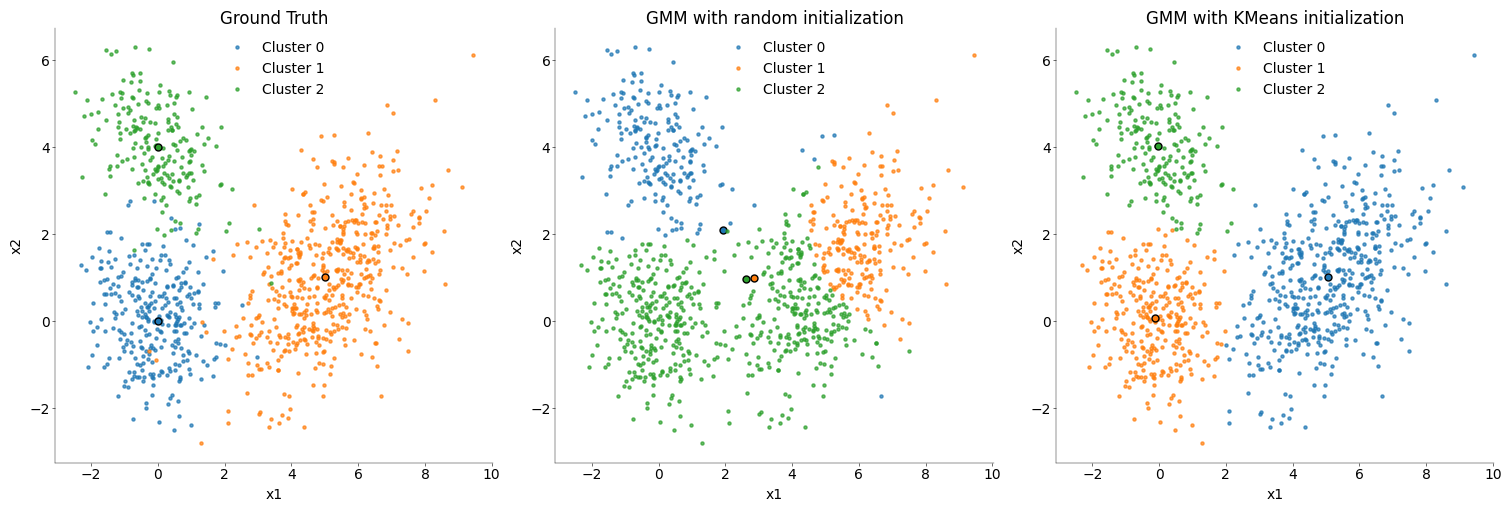

In [8]:
# -------------------------------------------------------------------------
# Run the algorithm 5 times on the toy data, plot and compare original and
# assigned clusters and answer the questions (1+1 pts)
# -------------------------------------------------------------------------

# run the GMM with random initialization
random_labels, m_random, S_random, p_random = fit_mog(
    x, n_clusters=3, n_iters=5, random_seed=0, init="random"
)

# run the GMM with k-means initialization
KMeans_labels, m_kmeans, S_kmeans, p_kmeans = fit_mog(
    x, n_clusters=3, n_iters=5, random_seed=0, init="kmeans"
)

# plot the results of the GMM with random initialization and KMeans and ground truth

fig, ax = plt.subplots(1, 3, figsize=(15, 5), layout="constrained")
ax[0].set_title("Ground Truth")
ax[1].set_title("GMM with random initialization")
ax[2].set_title("GMM with KMeans initialization")

# plot the points with different colors for each cluster
for i in range(len(m)):
    ax[0].scatter(
        x[ground_labels == i, 0],
        x[ground_labels == i, 1],
        s=20,
        alpha=0.7,
        label=f"Cluster {i}",
    )
    ax[0].scatter(m[i, 0], m[i, 1], s=100, c=f"C{i}", edgecolors="k", linewidths=1)
    ax[1].scatter(
        x[random_labels == i, 0],
        x[random_labels == i, 1],
        s=20,
        alpha=0.7,
        label=f"Cluster {i}",
    )
    ax[1].scatter(
        m_random[i, 0], m_random[i, 1], s=100, c=f"C{i}", edgecolors="k", linewidths=1
    )
    ax[2].scatter(
        x[KMeans_labels == i, 0],
        x[KMeans_labels == i, 1],
        s=20,
        alpha=0.7,
        label=f"Cluster {i}",
    )
    ax[2].scatter(
        m_kmeans[i, 0], m_kmeans[i, 1], s=100, c=f"C{i}", edgecolors="k", linewidths=1
    )


[ax[i].set_xlabel("x1") for i in range(3)]
[ax[i].set_ylabel("x2") for i in range(3)]
[ax[i].legend() for i in range(3)]
plt.show()

### Questions

1) Do all runs converge to good solutions? If not, which one would you pick (only visual inspection required) as the best one?

Within 5 iterations, the randomly initialized GMM was could not converge to a sufficient cluster assignment especially for the data points of cluster 1 and 2. On the hand, the k-means initialized GMM was able to correctly assign almost every data point to the correct cluster. This is due to the fact that the k-means based initialization already assigns the cluster centers and prior probabilities based on distances of data points to the cluster centers. This way, it also avoids that the GMM algorithm gets stuck in poor local minima.

2) Do you get the same colors (=labels) in your best assignment(s) compared to the groundtruth? Does it have to be that way or not? Why?

When synthesizing the ground truth data, some points were randomly chosen to be very far from the original cluster centers. By nature, the GMM assigned these data points to the cluster whose center was closest and not according to the original labelling. Except for the these outliers, the remaining assignments were the same.

## Bonus Task (Optional): Mixture of drifting t-distributions

Instead of a simple Gaussian Mixture Model, more advanced algorithms can be implemented.
Implement a basic version of the mixture of drifting t-distributions (follow https://github.com/aecker/moksm/blob/master/MoT_Kalman.pdf).
What is the advantage of that method?

_Grading: 2 BONUS Points._


_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

In [11]:
# create a basic t-shiftiing distribution
def fit_mot_kalman(
    x: np.ndarray,
    spiketimes: np.ndarray,
    n_clusters: int,
    n_iters: int = 10,
    df: float = 4.0,
    Q: float = 1e-3,
    random_seed: int = 0,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Fit a mixture of drifting multivariate t‑distributions using a Kalman‐like update.
    Parameters
    ----------
    x           : (N, D) data
    spiketimes  : (N,) time stamps for drift modeling
    n_clusters  : number of mixture components
    n_iters     : EM iterations
    df          : degrees of freedom for the t‑distribution
    Q           : process noise covariance (drift strength)
    random_seed : RNG seed, ensures reproducibility
    Returns
    -------
    labels : (N,) hard assignments
    m      : (K, D) estimated means
    S      : (K, D, D) estimated covariances
    p      : (K,) mixing proportions
    """
    rng = np.random.default_rng(random_seed)
    N, D = x.shape
    t = spiketimes - spiketimes.min()
    # init via KMeans
    km = KMeans(n_clusters=n_clusters, random_state=random_seed).fit(x)
    labels = km.labels_
    m = km.cluster_centers_.copy()
    S = np.array(
        [np.cov(x[labels == k].T) + 1e-6 * np.eye(D) for k in range(n_clusters)]
    )
    p = np.array([np.mean(labels == k) for k in range(n_clusters)])
    Qk = [Q * np.eye(D) for _ in range(n_clusters)]

    for it in range(n_iters):
        # E‑step: responsibilities under Student‑t (instead of gamma as in the paper)
        r = np.zeros((N, n_clusters))
        for k in range(n_clusters):
            diff = x - m[k]
            invS = np.linalg.inv(S[k])
            maha = np.sum(diff @ invS * diff, axis=1)
            const = gamma((df + D) / 2) / (
                gamma(df / 2) * (df * np.pi) ** (D / 2) * np.sqrt(np.linalg.det(S[k]))
            )
            r[:, k] = p[k] * const * (1 + maha / df) ** (-(df + D) / 2)
        r /= r.sum(axis=1, keepdims=True)
        print(
            f"\rIteration {it+1}/{n_iters}, max r: {r.max():.3f}, min r: {r.min():.3f}"
        )
        # M‑step
        Nk = r.sum(axis=0)
        p = Nk / N

        # update means with simple drift term (Kalman like-but not as complex as in the paper)
        for k in range(n_clusters):
            wk = r[:, k]
            # weighted least squares of x on time t to estimate drift slope & intercept
            A = np.vstack([np.ones(N), t]).T
            W = np.diag(wk)
            coeffs = np.linalg.inv(A.T @ W @ A) @ (A.T @ (W @ x))
            # intercept is coeffs[0,:], slope is coeffs[1,:]
            m[k] = coeffs[0] + coeffs[1] * t.mean()
            # covariance update + process noise
            diff = x - m[k]
            S[k] = (wk[:, None] * diff).T @ diff / Nk[k] + Qk[k]

    labels = r.argmax(axis=1)
    return labels, m, S, p

In [13]:
def generate_drifting_toy(
    N: int = 1000,
    D: int = 2,
    K: int = 3,
    Tmax: float = 100.0,
    random_seed: int = 0,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate N points in D dims from K clusters whose means drift linearly in time.
    Returns (x, t, labels).
    """
    rng = np.random.default_rng(random_seed)
    # mixing proportions
    p = np.array([0.3, 0.5, 0.2])
    # static intercepts and per‐cluster drift slopes
    intercepts = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])
    slopes = np.array([[0.05, -0.02], [0.0, 0.03], [-0.04, 0.01]])
    # constant covariance for noise
    covs = np.array([0.5 * np.eye(D) for _ in range(K)])
    # sample labels and times
    labels = rng.choice(K, size=N, p=p)
    t = rng.uniform(0.0, Tmax, size=N)
    # sample features
    x = np.zeros((N, D))
    for k in range(K):
        idx = labels == k
        tk = t[idx][:, None]
        mu_t = intercepts[k] + slopes[k] * tk
        x[idx] = rng.multivariate_normal(np.zeros(D), covs[k], size=idx.sum()) + mu_t
    return x, t, labels

Iteration 1/10, max r: 0.999, min r: 0.000
Iteration 2/10, max r: 0.998, min r: 0.000
Iteration 3/10, max r: 0.998, min r: 0.000
Iteration 4/10, max r: 0.998, min r: 0.000
Iteration 5/10, max r: 0.998, min r: 0.000
Iteration 6/10, max r: 0.998, min r: 0.000
Iteration 7/10, max r: 0.998, min r: 0.000
Iteration 8/10, max r: 0.998, min r: 0.000
Iteration 9/10, max r: 0.998, min r: 0.000
Iteration 10/10, max r: 0.998, min r: 0.000


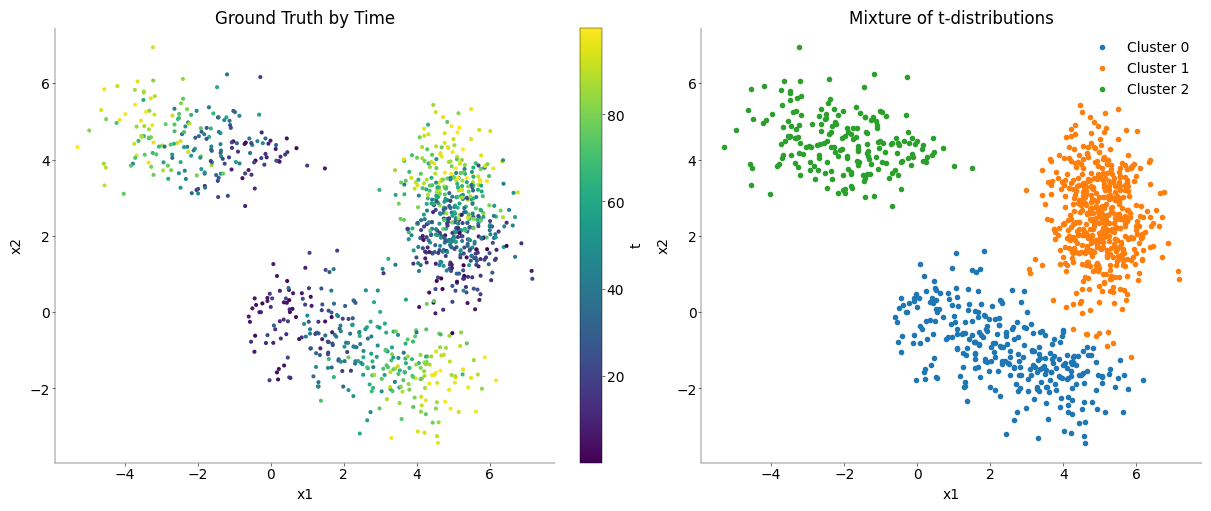

In [19]:
# create toy data
x, t, ground_labels = generate_drifting_toy(N=1000, D=2, K=3, Tmax=100, random_seed=42)

# test the fit_mot_kalman function
mot_labels, m_mot, S_mot, p_mot = fit_mot_kalman(
    x, t, n_clusters=3, n_iters=10, df=4.0, Q=1e-3, random_seed=42
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Left: points colored by time, with a colorbar
sc_time = axes[0].scatter(x[:, 0], x[:, 1], c=t, cmap="viridis", s=15)
axes[0].set_title("Ground Truth by Time")
cbar = fig.colorbar(sc_time, ax=axes[0])
cbar.set_label("t")

# Right: points colored by predicted cluster, with a legend
scatter_clusters = []
[axes[1].scatter(x[mot_labels == i, 0], x[mot_labels == i, 1]) for i in range(3)]

axes[1].set_title("Mixture of t-distributions")

[axes[i].set_xlabel("x1") for i in range(2)]
[axes[i].set_ylabel("x2") for i in range(2)]
axes[1].legend([f"Cluster {i}" for i in range(3)])

plt.show()

(20534, 30, 4)

## Advantage over classical GMM

By design, the mixture of drifting t-distributions consideres the temporal drift of the data points using a Kalman filter. This allows to track the cluster centers over time and adapt to changes in the data distribution. This is especially useful for electrophysiological recordings, where noise like electrode drift can decrease data quality and might lead to misclassification of data points. Additionally, the t-distribution is more robust to outliers due to its heavier tails and fits non-Gaussian noise better. Compared to the original and complex algorithm of the paper, we simplified the mixture model by using a reduced Kalman filter, less complex t-distribution and less latent variables.

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 5 pts*



### Question (0.5 pts)

1) What is the number of parameters of the model?

$P = \dots$

In [ ]:
def mog_bic(
    x: np.ndarray, m: np.ndarray, S: np.ndarray, p: np.ndarray
) -> tuple[float, float]:
    """Compute the BIC for a fitted Mixture of Gaussian model

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    m: np.array, (n_clusters, n_dims)
        Means

    S: np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.array, (n_clusters, )
        Cluster weights / probablities

    Return
    ------

    bic: float
        BIC

    LL: float
        Log Likelihood
    """

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------

    pass

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# Compute and plot the BIC for mixture models with different numbers of clusters (e.g., 2 - 6). (0.5 pts)
# Make your _estimate of the BIC_ robust against local minima, regardless of the initialization strategy used (0.5 pts)
# ----------------------------------------------------------------------------------------------------------------------

K = np.arange(2, 7)
num_seeds = 10

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here

In [ ]:
# ------------------------------------------------------------------------------------------
# Plot the result and answer the questions (1+1 pts)
# Don't forget to plot your robust estimate and highlight the estimated number of clusters!
# ------------------------------------------------------------------------------------------

### Questions

1) What happens to the BIC if the model got stuck in a local minimum? For your reasoning, you can also refer to Task 2.

_YOUR ANSWER HERE_

2) The goal is to estimate which number of clusters best fits the data using the BIC. Therefore, what qualifies as a robust estimate? Explain your reasoning!
   
_(Hint: think about which number of cluster you would use and why)_

_YOUR ANSWER HERE_

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (MoG fitting + model complexity selection).

Show the plot of the BIC as a function of the number of mixture components on the real data, highlight the robust estimate and based on that the best number of clusters.

For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot.

*Grading: 3 pts*


In [ ]:
# -------------------------------------------------------------
# Run the algorithm on the set of extracted features (0.5 pts)
# -------------------------------------------------------------

K = np.arange(2, 16)
num_seeds = 5

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# Plot the BIC over number of mixture components and highlight robust estimate and optimal number of clusters (0.5 pts)
# ----------------------------------------------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(4, 4))

Refit model with lowest BIC and plot data points

In [ ]:
random_seed, kk = np.where(BIC == BIC.min())
random_seed = random_seed[0]
kk = kk[0]
print(f"lowest BIC: # cluster = {K[kk]}")
# a, m, S, p = fit_mog(b, K[kk], random_seed=random_seed, init="kmeans")

In [ ]:
# ------------------------------------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all pairwise combinations of the 4 channels. (1 pt)
# ------------------------------------------------------------------------------------------------------------------


## Task 5: Cluster separation and Correlograms

As postprocessing, implement the calculation of auto- and cross correlograms over the spike times.

Plot the (auto-/cross-) correlograms, displaying a time frame of -30ms to +30ms. Choose a good bin size and interprete the resulting diagrams.

_Grading: 3 pts_

#### Hints

_It is faster to calculate the histogram only over the spiketimes that are in the displayed range. Filter the spike times before calculating the histogram!_

_For the autocorrelogram, make sure not to include the time difference between a spike and itself (which would be exactly 0)_

_For the correlogram an efficient implementation is very important - looping over all spike times is not feasible. Instead, make use of numpy vectorization and broadcasting - you can use functions such as tile or repeat._

In [ ]:
# ----------------------------------------------------------------------
# Implement a function for calculating the spike time differences (1pt)
# ----------------------------------------------------------------------
def cross_time_diff(spiketimes1: np.ndarray, spiketimes2: np.ndarray) -> np.ndarray:
    """Compute the pairwise time differences between two sets of spike times.

    Parameters
    ----------
    spiketimes1: np.ndarray, (n_spikes1, )
        Spike times of the first cluster
    spiketimes2: np.ndarray, (n_spikes2, )
        Spike times of the second cluster

    Return
    ------

    time_diff: np.ndarray, (n_spikes1, n_spikes2)
        Pairwise time differences between the two sets of spike times
        (i.e., spiketimes1[i] - spiketimes2[j])
    """
    pass

In [ ]:
# -----------------------------------------------------------------------------------
# Calculate and plot auto- and cross correlograms and answer the questions (1+1 pts)
# -----------------------------------------------------------------------------------

### Questions
1) Based on the plot, do you see clusters that contain spikes likely from a single neuron?

_YOUR ANSWER HERE_

2) Do you see cases where plural clusters might come from the same neuron?

_YOUR ANSWER HERE_

3) Do you see clusters that might contain spikes from plural neurons?

_YOUR ANSWER HERE_

4) Explain the term "refractory period" and how one can see it in this plot.

_YOUR ANSWER HERE_